In [1]:
import pandas as pd
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil
from datetime import datetime
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [215]:
def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False
    ):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if a legend is present.
        if ax.get_legend():
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'Figures/Plots/{file}.pdf', format = 'pdf', dpi = 600,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()
    

In [2]:
CSVs = glob('data/*/*.csv')

for csv in CSVs:
    csv = csv.replace('\\', '/')
    file = match(r'data.*/(.*?)\.csv', csv).group(1)
    print(file)
    exec(f'{file} = pd.read_csv("{csv}")')
    exec(f'{file}["state"] = "{file.split('_')[-1].upper()}"')


forecastdemand_qld
forecastdemand_sa
forecastdemand_vic
temprature_qld
temprature_sa
temprature_vic
totaldemand_qld
totaldemand_sa
totaldemand_vic
forecastdemand_nsw
temperature_nsw
totaldemand_nsw


In [3]:
dem = pd.concat([totaldemand_qld, totaldemand_sa, totaldemand_vic])

dem.DATETIME = pd.to_datetime(dem.DATETIME, format="%Y-%m-%d %H:%M:%S")
totaldemand_nsw.DATETIME = pd.to_datetime(totaldemand_nsw.DATETIME, format="%d/%m/%Y %H:%M")
dem = pd.concat([dem, totaldemand_nsw]).reset_index(drop=True)\
    .drop(columns=['REGIONID'])

print(dem.isnull().sum())

dem


DATETIME       0
TOTALDEMAND    0
state          0
dtype: int64


DATETIME  TOTALDEMAND state
0      2010-01-01 00:00:00      5561.21   QLD
1      2010-01-01 00:30:00      5422.25   QLD
2      2010-01-01 01:00:00      5315.98   QLD
3      2010-01-01 01:30:00      5186.70   QLD
4      2010-01-01 02:00:00      5050.83   QLD
...                    ...          ...   ...
786046 2021-03-17 22:00:00      7419.77   NSW
786047 2021-03-17 22:30:00      7417.91   NSW
786048 2021-03-17 23:00:00      7287.32   NSW
786049 2021-03-17 23:30:00      7172.39   NSW
786050 2021-03-18 00:00:00      7094.51   NSW

[786051 rows x 3 columns]

In [4]:
fore = pd.concat([
    forecastdemand_qld, forecastdemand_sa, forecastdemand_vic, forecastdemand_nsw
]).drop(columns=['REGIONID'])

for col in ["LASTCHANGED", "DATETIME"]:
    fore[col] = pd.to_datetime(fore[col], format="%Y-%m-%d %H:%M:%S")

print(fore.isnull().sum())

fore


PREDISPATCHSEQNO    0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
state               0
dtype: int64


PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND         LASTCHANGED  \
0               2016123018        71         6425.36 2016-12-30 12:31:25   
1               2016123018        72         6193.34 2016-12-30 12:31:25   
2               2016123018        73         6016.45 2016-12-30 12:31:25   
3               2016123018        74         5859.23 2016-12-30 12:31:25   
4               2016123018        75         5767.15 2016-12-30 12:31:25   
...                    ...       ...             ...                 ...   
10906014        2021031736         5         7028.45 2021-03-17 21:31:31   
10906015        2021031737         4         7041.65 2021-03-17 22:01:34   
10906016        2021031738         3         7087.60 2021-03-17 22:31:36   
10906017        2021031739         2         7087.28 2021-03-17 23:01:36   
10906018        2021031740         1         7126.37 2021-03-17 23:31:33   

                    DATETIME state  
0        2017-01-01 00:00:00   QLD  
1        2017-01-01 00:30:00   QLD  
2        2017-01-01 01:00:00   QLD  
3        2017-01-01 01:30:00   QLD  
4        2017-01-01 02:00:00   QLD  
...                      ...   ...  
10906014 2021-03-18 00:00:00   NSW  
10906015 2021-03-18 00:00:00   NSW  
10906016 2021-03-18 00:00:00   NSW  
10906017 2021-03-18 00:00:00   NSW  
10906018 2021-03-18 00:00:00   NSW  

[23192795 rows x 6 columns]

In [5]:
temp = pd.concat([temprature_qld, temperature_nsw, temprature_vic])
temp.DATETIME = pd.to_datetime(temp.DATETIME, format="%d/%m/%Y %H:%M")

temprature_sa.DATETIME = pd.to_datetime(temprature_sa.DATETIME, format="%Y-%m-%d %H:%M:%S")
temp = pd.concat([temp, temprature_sa])\
    .drop(columns = ['Unnamed: 0', 'LOCATION']).reset_index(drop=True)

print(temp.isnull().sum())

temp


DATETIME       0
TEMPERATURE    0
state          0
dtype: int64


DATETIME  TEMPERATURE state
0      2010-01-01 00:00:00         23.6   QLD
1      2010-01-01 00:30:00         23.7   QLD
2      2010-01-01 01:00:00         23.5   QLD
3      2010-01-01 01:30:00         22.6   QLD
4      2010-01-01 02:00:00         22.0   QLD
...                    ...          ...   ...
778172 2021-03-17 22:00:00         19.6    SA
778173 2021-03-17 22:30:00         19.5    SA
778174 2021-03-17 23:00:00         19.4    SA
778175 2021-03-17 23:30:00         19.6    SA
778176 2021-03-18 00:00:00         19.5    SA

[778177 rows x 3 columns]

In [158]:
df = pd.merge(temp, dem, on=['DATETIME', 'state'], how='outer')\
    .dropna()
df = df[df.state == 'NSW'].reset_index(drop=True)

# mmatrix(df.sort_values('DATETIME'))

# ohe = OneHotEncoder(sparse_output=False)
# df[sorted(df.state.unique())] = ohe.fit_transform(df.state.to_numpy().reshape(-1, 1))
# df = df.drop(columns=['state'])
df['day'] = df.DATETIME.dt.strftime('%w').astype(int)
df['day_label'] = df.DATETIME.dt.strftime('%a')
df['is_weekday'] = df.day.between(1, 5)

df


DATETIME  TEMPERATURE state  TOTALDEMAND  day day_label  \
0      2010-01-01 00:00:00         23.1   NSW      8038.00    5       Fri   
1      2010-01-01 00:30:00         22.9   NSW      7809.31    5       Fri   
2      2010-01-01 01:00:00         22.6   NSW      7483.69    5       Fri   
3      2010-01-01 01:30:00         22.5   NSW      7117.23    5       Fri   
4      2010-01-01 02:00:00         22.5   NSW      6812.03    5       Fri   
...                    ...          ...   ...          ...  ...       ...   
195942 2021-03-17 22:00:00         19.7   NSW      7419.77    3       Wed   
195943 2021-03-17 22:30:00         19.5   NSW      7417.91    3       Wed   
195944 2021-03-17 23:00:00         19.1   NSW      7287.32    3       Wed   
195945 2021-03-17 23:30:00         18.8   NSW      7172.39    3       Wed   
195946 2021-03-18 00:00:00         18.6   NSW      7094.51    4       Thu   

        is_weekday  
0             True  
1             True  
2             True  
3             True  
4             True  
...            ...  
195942        True  
195943        True  
195944        True  
195945        True  
195946        True  

[195947 rows x 7 columns]

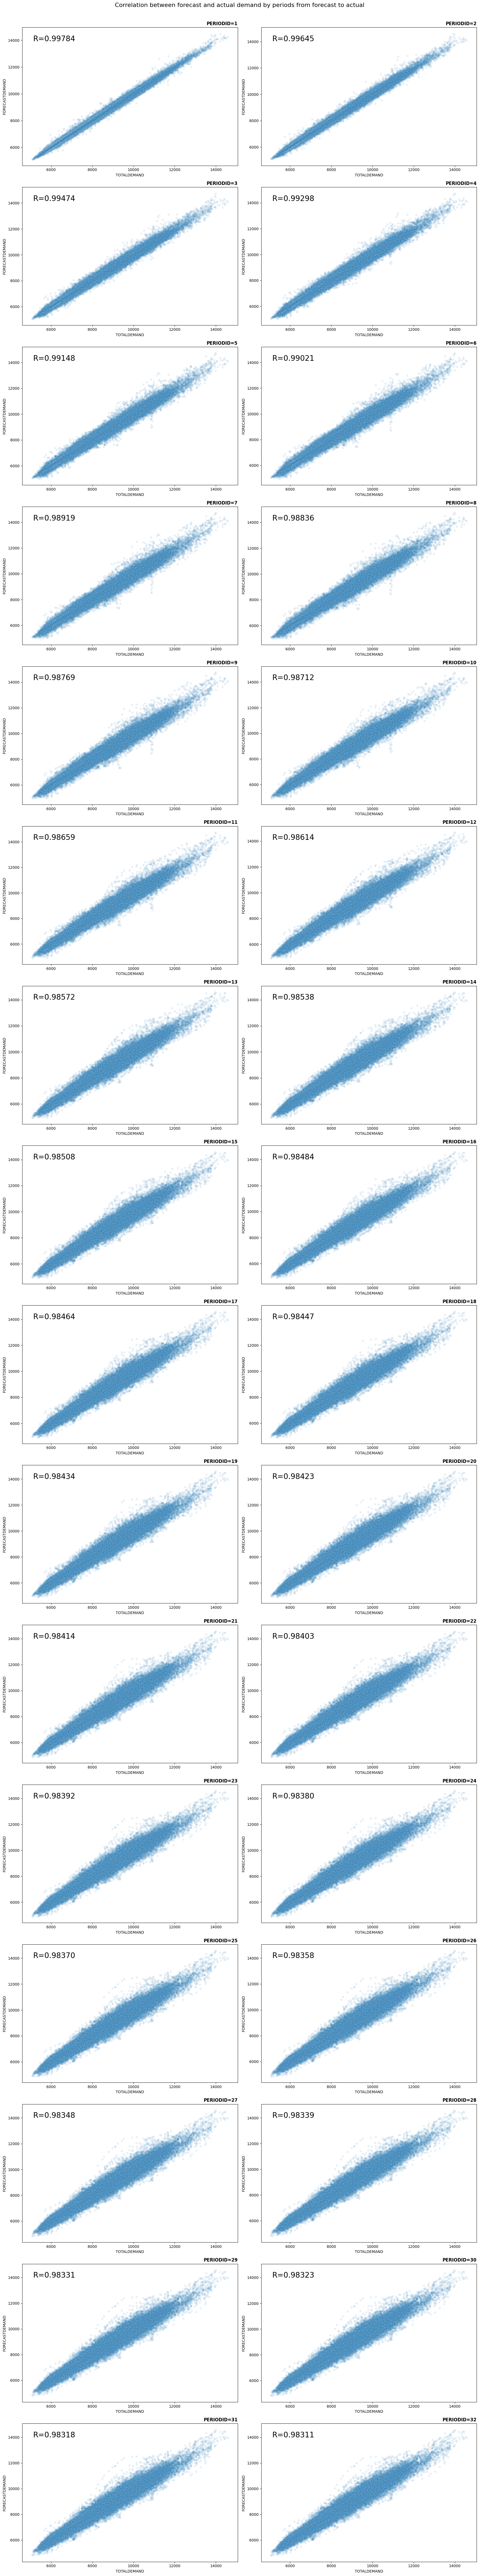

In [17]:
n, n_cols = 32, 2
n_rows = ceil(n/n_cols)
corrs = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 6*n_rows))
axes = axes.flatten()

for i in range(n, 0, -1):
    ax = axes[i-1]
    data = pd.merge(df, fore[fore.PERIODID == i][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
        .dropna().reset_index(drop=True)

    x, y ='TOTALDEMAND', 'FORECASTDEMAND'
    sns.scatterplot(data, x=x, y=y, ax=ax, alpha=0.1)
    corr = pearsonr(data[x], data[y]).statistic
    ax.text(0.05, .9, f"R={corr:.05f}", transform=ax.transAxes, fontsize=20)
    
    ax.set_title(f"PERIODID={i}", loc='right', fontweight=600)
    corrs.append({'PERIODID': i, 'correlation': corr})

plt.suptitle(
    'Correlation between forecast and actual demand by periods from forecast to actual', 
    fontsize=16, verticalalignment='bottom', y = 1
)
plt.tight_layout()
plt.show()


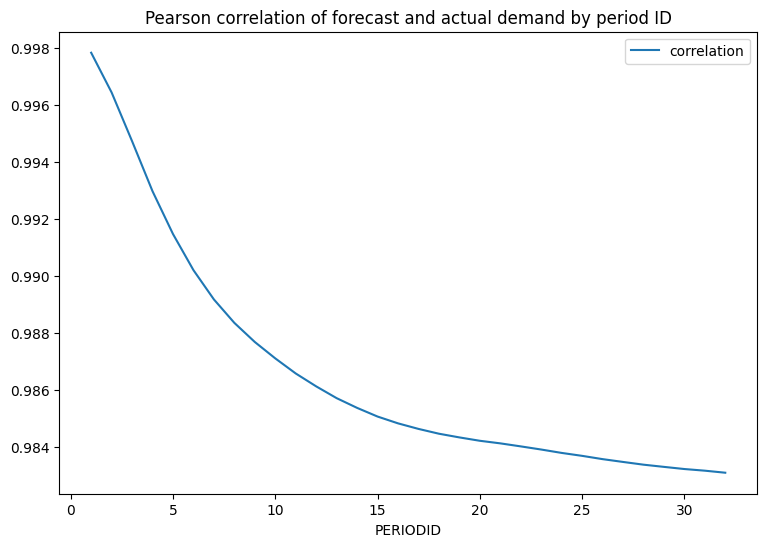

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))

pd.DataFrame(corrs).set_index('PERIODID').plot(ax=ax)
ax.set_title('Pearson correlation of forecast and actual demand by period ID')

plt.show()


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df.dropna().drop(columns=['TOTALDEMAND', 'DATETIME', 'state']), df.dropna().TOTALDEMAND, 
    test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

X_train


TEMPERATURE
138340         21.9
115476          7.1
127915         13.3
107054         22.2
39002          23.5
...             ...
76544          10.5
49678          25.4
159940         23.1
136294         16.6
61115           9.4

[117567 rows x 1 columns]

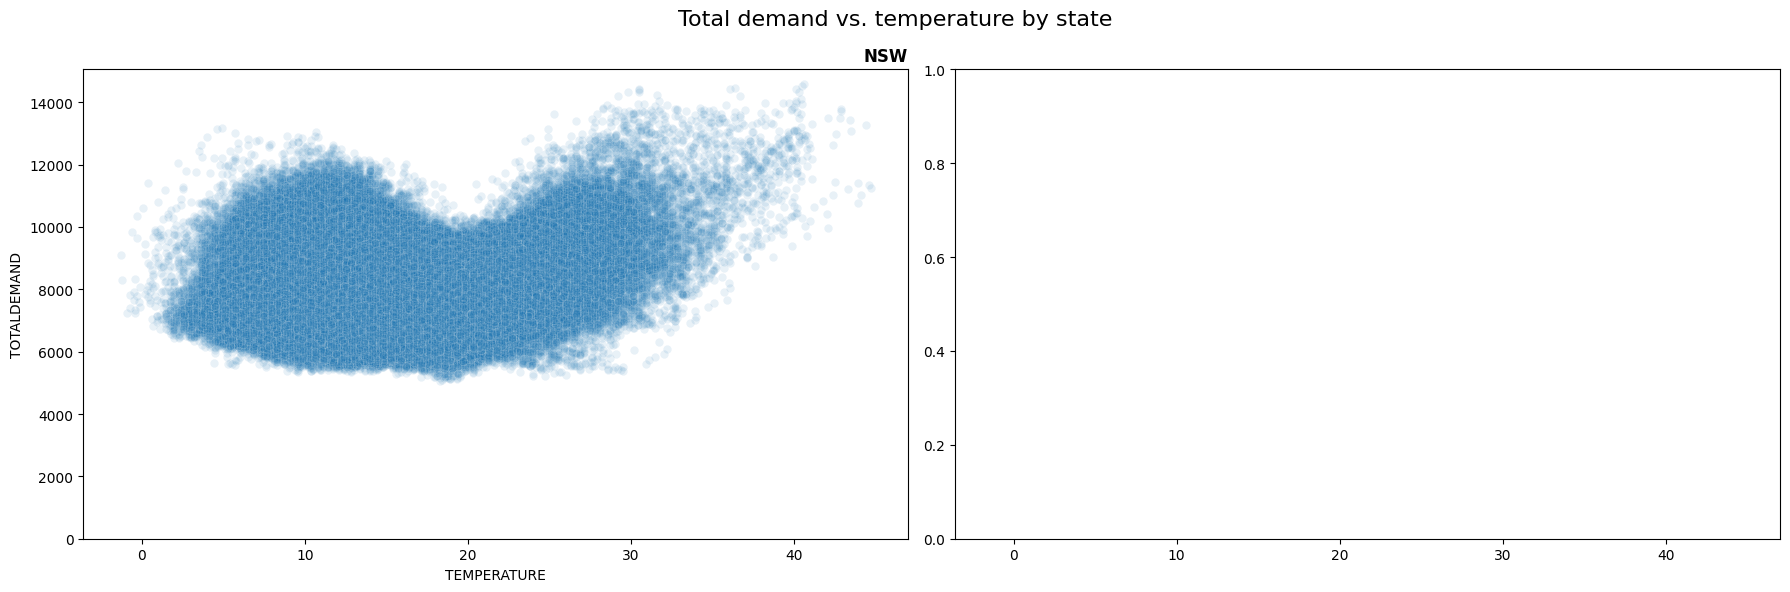

In [20]:
states = sorted(df.state.unique())
n, n_cols = len(states), 2
n_rows = ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 6*n_rows), sharex=True)
axes = axes.flatten()

for i, state in enumerate(states):
    ax = axes[i]
    sns.scatterplot(
        y='TOTALDEMAND', x='TEMPERATURE', ax=ax, data=df[df.state == state],#.sample(1000), 
        alpha=0.1
    )
    ax.set_title(state, loc ='right', fontweight=600)
    ax.set_ylim(0)

plt.suptitle('Total demand vs. temperature by state', fontsize=16)
plt.tight_layout()

plt.show()


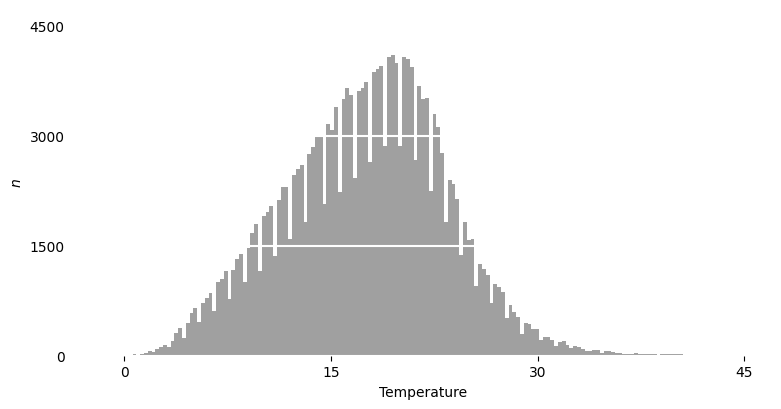

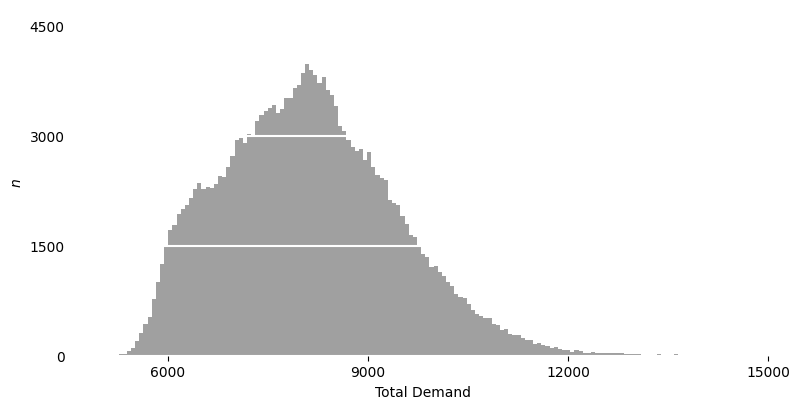

In [217]:
import matplotlib.ticker as ticker

for col in ['Temperature', 'Total Demand']:
    fig, ax = plt.subplots(figsize=(9, 4.5))
    col_label = col.replace(' ', '').upper()
    
    # df.TEMPERATURE.hist(ax = ax)
    sns.histplot(df, x=col_label, color='grey', lw=0, edgecolor='white')
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    for line in ax.get_yticks():
        ax.axhline(line, 0, max(ax.get_xticks()), color='white')
    
    for side in ax.spines:
        ax.spines[side].set_visible(False)
    
    ax.tick_params(axis='y', color='white')
    ax.set_xlabel(col)
    ax.set_ylabel('$n$')
    
    show(fig, [ax], file=f'{col} histogram')


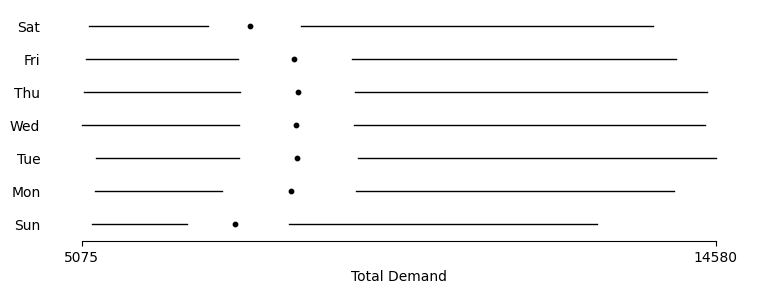

In [219]:
data = df.groupby(['day', 'day_label']).TOTALDEMAND.apply(list).sort_index()
medians = df.groupby('day').TOTALDEMAND.median()

fig, ax = plt.subplots(figsize=(9, 3))

ax.boxplot(
    x=data, vert=False, labels = [e[1] for e in data.index], showbox=False,
    medianprops={'linewidth': 0}, whis=5, showcaps=False
)
ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

ax.set_xlabel('Total Demand')

neaten_ticks(ax, 'x', [
    data.explode().to_frame().min().squeeze(), 
    data.explode().to_frame().max().squeeze()
], [])

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', left=False)

show(fig, [ax], file='Demand by day boxplots')


In [14]:
import tensorflow as tf


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy', 'mse']
)


In [21]:
start = datetime.now()

model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

print(datetime.now() - start)


Epoch 1/10
13575/13575 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.0000e+00 - loss: 12617880.0000 - mse: 12617880.0000 - val_accuracy: 0.0000e+00 - val_loss: 827722.3125 - val_mse: 827887.5000
Epoch 2/10
13575/13575 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.0000e+00 - loss: 808998.7500 - mse: 808998.7500 - val_accuracy: 0.0000e+00 - val_loss: 778665.7500 - val_mse: 778821.8750
Epoch 3/10
13575/13575 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.0000e+00 - loss: 775298.2500 - mse: 775298.2500 - val_accuracy: 0.0000e+00 - val_loss: 759497.3125 - val_mse: 759643.8750
Epoch 4/10
13575/13575 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.0000e+00 - loss: 760380.3750 - mse: 760380.3750 - val_accuracy: 0.0000e+00 - val_loss: 748488.8125 - val_mse: 748621.1875
Epoch 5/10
13575/13575 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.0000e+00 - loss: 750526.7500 - mse: 750526.7500 - val_accuracy: 0.0000e+00 - val_loss: 739701.5625 - val_mse: 739827.0000
Epoch 6/10
13575/13575 ━━━━━━━━

In [24]:
model.evaluate(X_val,  y_val, verbose=2)


4526/4526 - 6s - 1ms/step - accuracy: 0.0000e+00 - loss: 714211.7500 - mse: 714328.1250


[714211.75, 0.0, 714328.125]

In [26]:
y_pred = model.predict(X_val)

r2_score(y_val, y_pred)


4526/4526 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


0.9016066039647717

In [29]:
from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network


In [56]:
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(X_train.shape[0],X_train.shape[1]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=434400, activation='tanh', recurrent_activation='relu', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(X_train.shape[0], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=434400, activation='tanh', recurrent_activation='relu', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomNormalV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1303200,434400] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomNormalV2]

In [ ]:
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
    loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
    metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
)


In [ ]:
start = datetime.now()

history = model.fit(X_train, y_train, epochs=10)

print(datetime.now() - start)


In [41]:
y_train.isnull().sum()


0

In [55]:
start = datetime.now()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

mlp = MLPRegressor(
    hidden_layer_sizes=(10, 10, 10, 10, 10), solver='adam', 
    max_iter=1000, random_state=1
)
mlp.fit(X=X_train_scaled, y=y_train)
y_pred = mlp.predict(X_val_scaled)

print('Train time:', datetime.now() - start)
print('R-squared:', r2_score(y_val, y_pred))

mlp


Train time: 0:00:19.339882
R-squared: 0.9947232481914644


MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000,
             random_state=1)

**MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:02:50.626288  
R-squared: 0.903996701869163  

**MLPRegressor(hidden_layer_sizes=(30, 30, 30), max_iter=1000, random_state=1)**  
Train time: 0:07:13.764777  
R-squared: 0.9029300360828791  

  
**MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=1)**  
Train time: 0:04:49.145756  
R-squared: 0.904020785674071  

**MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=1)**  
Train time: 0:30:34.488262  
R-squared: 0.9042026519524867  
  
**MLPRegressor(hidden_layer_sizes=(1,), max_iter=1000, random_state=1)**  
Train time: 0:15:16.664206  
R-squared: -1.2258165361865667  

**MLPRegressor(hidden_layer_sizes=(5, 5, 5), max_iter=1000, random_state=1)**  
Train time: 0:07:20.061461  
R-squared: 0.9029303895811518  
  
**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:00:54.204514  
R-squared: 0.903889951968013  

**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10, 10, 10), max_iter=1000, random_state=1)**  
Train time: 0:02:17.239752  
R-squared: 0.8997796694909751  

**MLPRegressor(hidden_layer_sizes=(10, 10, 10, 10, 10), max_iter=1000, random_state=1, solver='sgd')**  
Train time: 0:10:37.488748  
R-squared: -2.325212494791451e-05  




In [121]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from urllib.parse import quote_plus


In [132]:
uri = "mongodb+srv://<user>:<password>@project-data.cfluj8d.mongodb.net/?retryWrites=true&w=majority&appName=project-data"\
    .replace('<user>', quote_plus(user)).replace('<password>', quote_plus(psw))

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
client.admin.command('ping')
print("Pinged your deployment. You successfully connected to MongoDB!")



Pinged your deployment. You successfully connected to MongoDB!


In [207]:
print(client.list_database_names())


['data', 'admin']
['forecast_demand', 'total_demand', 'temperature']


In [208]:
# client['data']['temperature'].insert_many(temp.to_dict(orient='records'))
# client['data']['total_demand'].insert_many(dem.to_dict(orient='records'))
# client['data']['forecast_demand'].insert_many(fore.to_dict(orient='records'))


In [210]:
for col in client['data'].list_collection_names():
    print(f"{col}: {client['data'][col].count_documents({}):,} records")
    

forecast_demand: 23,192,795 records
total_demand: 786,051 records
temperature: 778,177 records
